In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import json

'''
    INITIAL SET UP
'''
# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:,.10f}'.format
%matplotlib inline

# Load the data
# We have this defaulted to the folder OUTSIDE of your repo - please change it as needed
population = pd.read_csv('Population by Age and Sex - US, States, Counties.csv')

def load_json(file_name: str):
    with open(file_name, 'r') as file:
        file_data = json.load(file)
    rows = []
    for person in file_data:
        base_info = {
            "bioguide_id": person["id"].get("bioguide"),
            "govtrack_id": person["id"].get("govtrack"),
            "icpsr_id": person["id"].get("icpsr"),
            "wikipedia": person["id"].get("wikipedia"),
            "wikidata": person["id"].get("wikidata"),
            "first_name": person["name"]["first"],
            "last_name": person["name"]["last"],
            "gender": person["bio"].get("gender"),
            "birthday": person["bio"].get("birthday"),
        }
        for term in person["terms"]:
            row = base_info.copy()
            row.update({
                "type": term["type"],
                "start": term["start"],
                "end": term["end"],
                "state": term["state"],
                "district": term.get("district"),
                "party": term.get("party"),
                "class": term.get("class"),
            })
            rows.append(row)

    # Convert to DataFrame
    legislators = pd.DataFrame(rows)
    return legislators

# load both historical & current into dataframes
incumbent = load_json('legislators-current.json')
non_incumbent = load_json('legislators-historical.json')

# filter historical from people born after 1900
non_incumbent['birthday'] = pd.to_datetime(non_incumbent['birthday'])
non_incumbent = non_incumbent[non_incumbent['birthday'].dt.year >= 1900]
incumbent['birthday'] = pd.to_datetime(incumbent['birthday'])

# Convert terms start and end to datetime
incumbent['start'] = pd.to_datetime(incumbent['start'])
incumbent['end'] = pd.to_datetime(incumbent['end'])
non_incumbent['start'] = pd.to_datetime(non_incumbent['start'])
non_incumbent['end'] = pd.to_datetime(non_incumbent['end'])

# Change type column/values of type for readability
incumbent = incumbent.rename(columns={'type': 'chamber'})
incumbent['chamber'] = incumbent['chamber'].replace(
    {'rep': 'House'})
incumbent['chamber'] = incumbent['chamber'].replace(
    {'sen': 'Senate'})
grouped_incumbent = incumbent.groupby('bioguide_id').first().reset_index()

non_incumbent = non_incumbent.rename(columns={'type': 'chamber'})
non_incumbent['chamber'] = non_incumbent['chamber'].replace(
    {'rep': 'House'})
non_incumbent['chamber'] = non_incumbent['chamber'].replace(
    {'sen': 'Senate'})

# merged dataframe: all legislators incumbent & non_incumbent
all_legislators = pd.concat([incumbent, non_incumbent], ignore_index=True)

# Incumbent without grouping by bioguide_id have duplicated candidates due to multiple terms
merged = all_legislators.groupby('bioguide_id').first().reset_index()

all_legislators.head(10)

,bioguide_id,govtrack_id,icpsr_id,wikipedia,wikidata,first_name,last_name,gender,birthday,chamber,start,end,state,district,party,class
0,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,1993-01-05,1995-01-03,OH,13.0000000000,Democrat,NaN
1,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,1995-01-04,1997-01-03,OH,13.0000000000,Democrat,NaN
2,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,1997-01-07,1999-01-03,OH,13.0000000000,Democrat,NaN
3,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,1999-01-06,2001-01-03,OH,13.0000000000,Democrat,NaN
4,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,2001-01-03,2003-01-03,OH,13.0000000000,Democrat,NaN
5,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,2003-01-07,2005-01-03,OH,13.0000000000,Democrat,NaN
6,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,House,2005-01-04,2007-01-03,OH,13.0000000000,Democrat,NaN
7,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,Senate,2007-01-04,2013-01-03,OH,NaN,Democrat,1.0000000000
8,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,Senate,2013-01-03,2019-01-03,OH,NaN,Democrat,1.0000000000
9,B000944,400050,"29,389.0000000000",Sherrod Brown,Q381880,Sherrod,Brown,M,1952-11-09,Senate,2019-01-03,2025-01-03,OH,NaN,Democrat,1.0000000000


In [9]:
'''
    GROUPING FUNCTIONS for exploring and analyzing data
'''
def group_party(df):
    party_count = df.groupby(['party']).agg(
        party_count=('party', 'count'),
    ).reset_index()
    return party_count

def group_chamber(df):
    chamber_count = df.groupby(['chamber']).agg(
        chamber_count=('chamber', 'count'),
    ).reset_index()
    return chamber_count

def group_age(df):
    df['age'] = df['birthday'].apply(
        lambda x: min((datetime.now() - pd.to_datetime(x)).days // 365, 100))

    # Group by party and calculate age statistics
    age_summary = df.groupby(['party', 'type', 'gender']).agg(
        average_age=('age', 'mean'),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    # Format average_age to 2 decimal points without trailing zeros
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary

def group_gender(df):
    gender_count = df.groupby(['party', 'gender']).agg(
        count=('gender', 'count')
    ).reset_index()
    return gender_count

def group_years_of_service(df):
    df['years_of_service'] = (pd.to_datetime(
        df['end']) - pd.to_datetime(df['start'])).dt.days // 365

    # Group by party and calculate years of service statistics
    service_summary = df.groupby('party').agg(
        total_years=('years_of_service', 'sum'),
        average_years=('years_of_service', 'mean'),
        min_years=('years_of_service', 'min'),
        max_years=('years_of_service', 'max'),
    ).reset_index()
    return service_summary

def group_state_party(df):
    state_party_count = df.groupby(['state', 'party', 'type']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    return state_party_count

def group_dates(df):
    date_summary = df.groupby('party').agg(
        average_start=('start', lambda x: pd.to_datetime(x).mean()),
        median_start=('start', lambda x: pd.to_datetime(x).median()),
        average_end=('end', lambda x: pd.to_datetime(x).mean()),
        median_end=('end', lambda x: pd.to_datetime(x).median()),
    ).reset_index()
    return date_summary

def group_decade(df):
    # Add a "start_decade" column
    df['start_decade'] = pd.to_datetime(df['start']).dt.year // 10 * 10

    # Group by decade and party
    decade_summary = incumbent.groupby(['start_decade', 'party']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    return decade_summary

def group_top_states(df):
    top_states = df.groupby(['state', 'party', 'type']).agg(
        legislator_count=('bioguide_id', 'count')
    ).reset_index()
    # Sort and find the top states for each party
    top_states = top_states.sort_values(
        ['party', 'legislator_count'], ascending=[True, False])
    return top_states

def group_age_start(df):
    # Calculate age at term start
    df['age_at_start'] = df.apply(
        lambda row: (row['start'] - row['birthday']).days // 365, axis=1)

    # Group by start date and calculate average age
    avg_age_by_term = df.groupby('start').agg(
        average_age=('age_at_start', 'mean')
    ).reset_index()

    avg_age_by_term['average_age'] = avg_age_by_term['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return avg_age_by_term

def age_by_party(df):
    age_summary = df.groupby('party').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary

def age_by_chamber(df):
    age_summary = df.groupby('chamber').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary

def age_by_gender(df):
    age_summary = df.groupby('gender').agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary

def age_by_all(df):
    age_summary = df.groupby(['party', 'chamber', 'gender']).agg(
        count=('party', 'count'),
        average_age=('age', 'mean'),
        median_age=('age', 'median'),
        mode_age=('age', lambda x: x.mode(
        ).iloc[0] if not x.mode().empty else None),
        min_age=('age', 'min'),
        max_age=('age', 'max'),
    ).reset_index()
    age_summary['average_age'] = age_summary['average_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    age_summary['median_age'] = age_summary['median_age'].map(
        lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
    )
    return age_summary

def gender_by_party(df):
    # Group by party and gender, then count
    gender_party_counts = df.groupby(
        ['party', 'gender']).size().reset_index(name='count')

    # Calculate total counts for each party
    total_by_party = gender_party_counts.groupby(
        'party')['count'].transform('sum')

    # Add a proportion column
    gender_party_counts['proportion'] = gender_party_counts['count'] / \
        total_by_party
    return gender_party_counts

def gender_by_chamber(df):
    # Group by chamber and gender, then count
    gender_chamber_counts = df.groupby(
        ['chamber', 'gender']).size().reset_index(name='count')

    # Calculate total counts for each chamber
    total_by_chamber = gender_chamber_counts.groupby(
        'chamber')['count'].transform('sum')

    # Add a proportion column
    gender_chamber_counts['proportion'] = gender_chamber_counts['count'] / \
        total_by_chamber
    return gender_chamber_counts

def add_age(df):
    df['age'] = df.apply(
        lambda row: (row['start'] - row['birthday']).days // 365, axis=1
    )

In [3]:
'''
    CONGRESS ANALYSIS
'''
# Party Affil Stats - Dems/Repubs
all_party = group_party(merged)

# Chamber Stats - House(rep)/Senate(sen)
all_chamber = group_chamber(merged)

add_age(merged)

# Age Stats by Party
all_age_party = age_by_party(merged)

# Age Stats by Chamber
all_age_chamber = age_by_chamber(merged)

# Age Stats By Gender
all_age_gender = age_by_gender(merged)

# Age Stats By All
all_age_all = age_by_all(merged)

# Gender by Party
all_gender_party = gender_by_party(merged)

# Gender by Chamber
all_gender_chamber = gender_by_chamber(merged)

In [4]:
# Add data label to each bar
def label_bars(ax):
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()  # Get the height of each bar
            if height > 0:  # Only label bars with a positive height
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X-coordinate
                    height,  # Y-coordinate (bar height)
                    f'{height:.1f}',  # Label text (formatted to 1 decimal place)
                    ha='center', va='bottom', fontsize=10  # Center alignment
                )

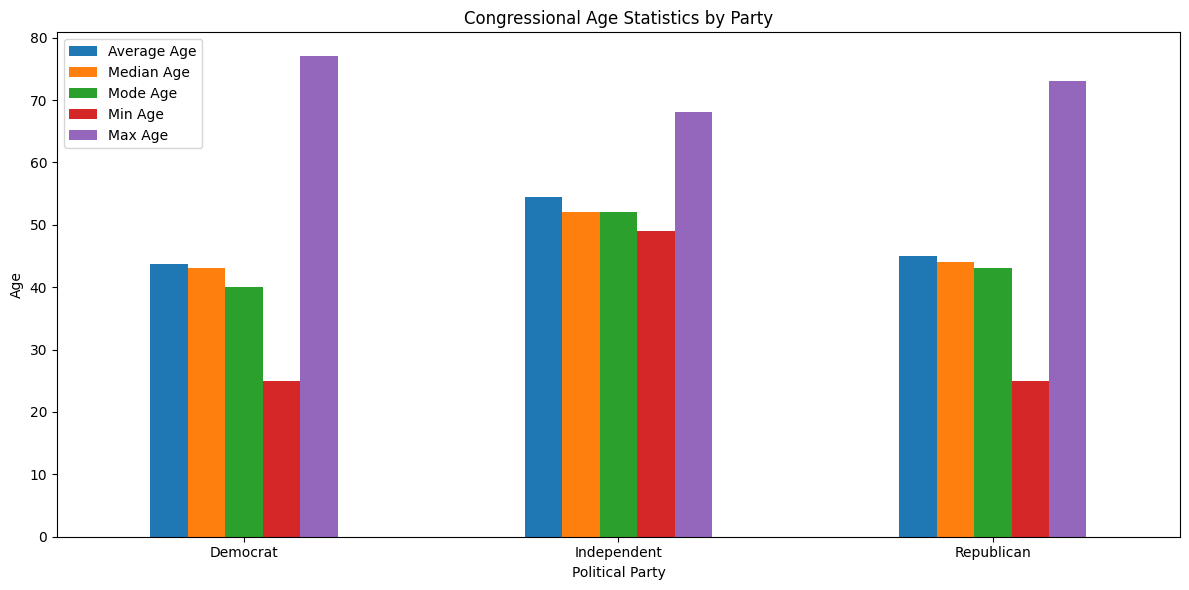

In [5]:
# Age Chart By Party
all_age_party = all_age_party[all_age_party['party'].isin(['Democrat', 'Republican', 'Independent'])]
all_age_party = all_age_party.astype({'min_age': 'float64', 'average_age': 'float64',
                                     'median_age': 'float64', 'mode_age': 'float64', 'max_age': 'float64'})
plot_age_party = all_age_party.set_index('party')
ax = plot_age_party[['average_age', 'median_age', 'mode_age', 'min_age', 'max_age']].plot(
    kind='bar', figsize=(12, 6))  # , 'median_age', 'mode_age'
label_bars
plt.title('Age Statistics by Political Party')
plt.xlabel('Political Party')
plt.ylabel('Age')
plt.xticks(rotation=0)
plt.legend(['Average Age', 'Median Age', 'Mode Age', 'Min Age', 'Max Age'])
plt.title('Congressional Age Statistics by Party')
plt.tight_layout()
plt.show()

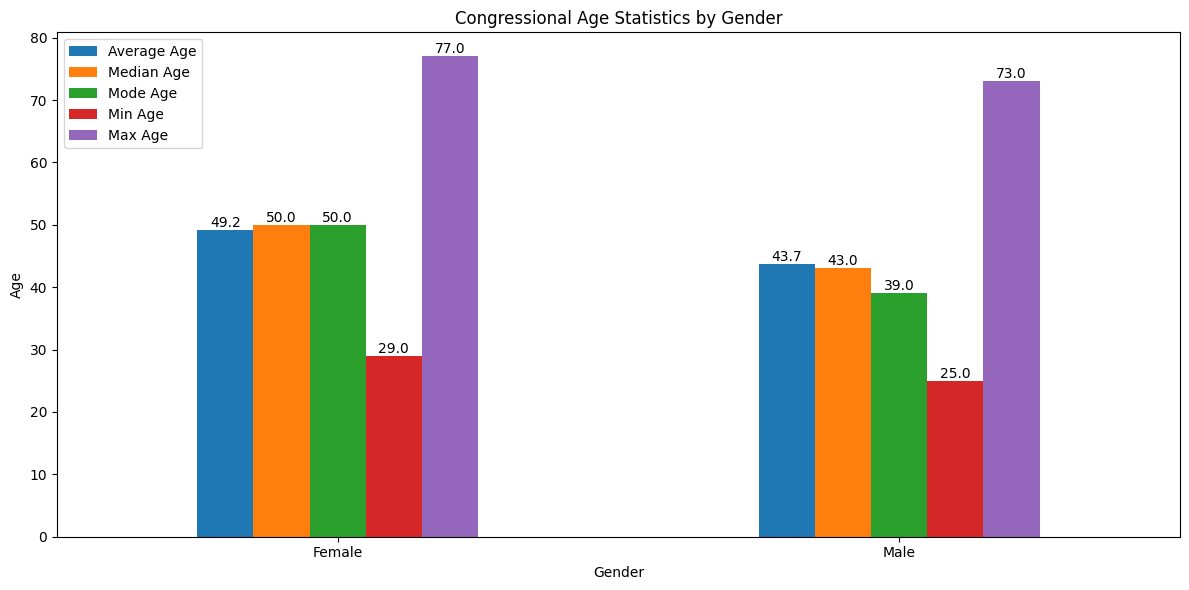

In [6]:
# Age Chart By Gender
all_age_gender = all_age_gender.astype({'count': 'float64', 'min_age': 'float64', 'average_age': 'float64', 'median_age': 'float64', 'mode_age': 'float64', 'max_age': 'float64'})
plot_age_gen = all_age_gender.set_index('gender')
ax = plot_age_gen[['average_age', 'median_age', 'mode_age',
              'min_age', 'max_age']].plot(kind='bar', figsize=(12, 6))
label_bars(ax)
            
plt.xlabel('Gender')
plt.ylabel('Age')
ax.set_xticklabels(
    ['Female' if label == 'F' else 'Male' for label in plot_age_gen.index], rotation=0)
plt.legend(['Average Age', 'Median Age', 'Mode Age', 'Min Age', 'Max Age'])
plt.title('Congressional Age Statistics by Gender')
plt.tight_layout()
plt.show()

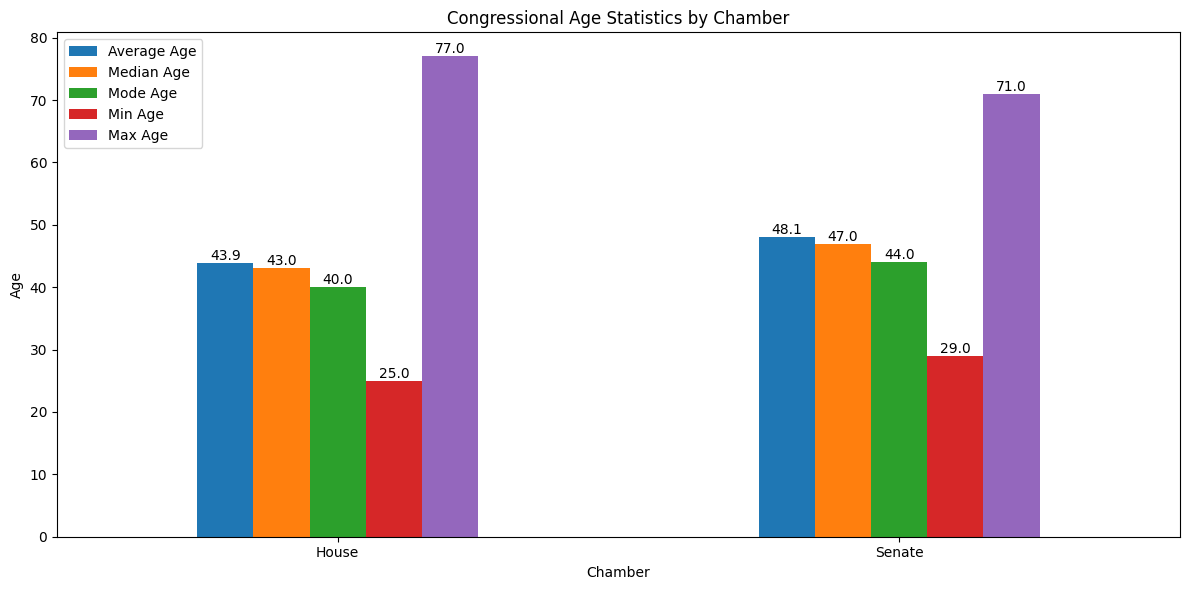

In [7]:
# Age Chart By Chamber
all_age_chamber = all_age_chamber.astype({'min_age': 'float64', 'average_age': 'float64',
                                     'median_age': 'float64', 'mode_age': 'float64', 'max_age': 'float64'})
plot_age_chamber = all_age_chamber.set_index('chamber')
ax = plot_age_chamber[['average_age', 'median_age', 'mode_age', 'min_age', 'max_age']].plot(
    kind='bar', figsize=(12, 6))  # , 'median_age', 'mode_age'
label_bars(ax)

plt.title('Age Statistics by Political Party')
plt.xlabel('Chamber')
plt.ylabel('Age')
plt.xticks(rotation=0)
plt.legend(['Average Age', 'Median Age', 'Mode Age', 'Min Age', 'Max Age'])
plt.title('Congressional Age Statistics by Chamber')
plt.tight_layout()
plt.show()

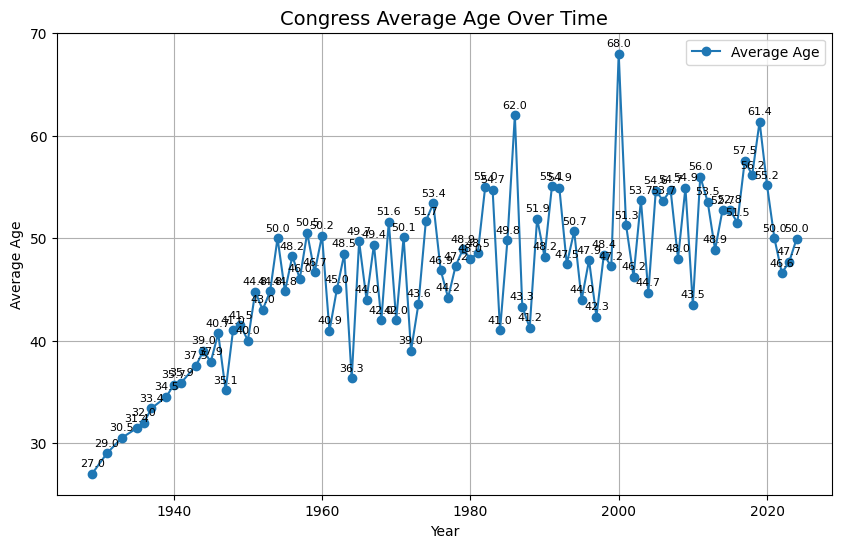

In [13]:
# CONGRESS AGE OVER TIME
# Use the entire all_legislators dataset to track new cohorts each new term
# Compare US Population Age to every new Congress term

all_avg_over_time = group_age_start(all_legislators)
all_avg_over_time['year'] = all_avg_over_time['start'].dt.year
all_avg_over_time['average_age'] = pd.to_numeric(
    all_avg_over_time['average_age'], errors='coerce')
all_avg_over_time = all_avg_over_time.groupby('year').agg(
    average_age=('average_age', 'mean')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(all_avg_over_time['year'],
         all_avg_over_time['average_age'], marker='o', label='Average Age')

# Annotate each point with its year and average age
for i, row in all_avg_over_time.iterrows():
    # Annotate average age slightly below the point
    plt.text(row['year'], row['average_age'] + .5,  # Adjust y-coordinate for average age
             f"{row['average_age']:.1f}", fontsize=8, ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Congress Average Age Over Time', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
'''
    POPULATION ANALYSIS
'''
filtered_pop = population[population['Description'] == 'U.S.']

# Remove unnecessary columns
filtered_pop = filtered_pop.drop(
    ['IBRC_Geo_ID', 'Statefips', 'Countyfips'], axis=1)

# Function to get percentages of populations
def percent(row, name):
    base = row['Total Population']
    return row[name]/base


for c in filtered_pop.columns:
    if 'population' in c.lower():
        filtered_pop['% ' +
                     c] = filtered_pop.apply(lambda row: percent(row, c), axis=1)

def get_avg_age(row):
    base = row['Total Population']
    populations = [row['Population 0-4'], row['Population 5-17'], row['Population 18-24'],
                   row['Population 25-44'], row['Population 45-64'], row['Population 65+']]  # Populations by group
    midpoints = [2.5, 11, 21, 34.5, 54.5, 75]  # Midpoints of age groups
    weighted_ages = sum(pop * mid for pop, mid in zip(populations, midpoints))
    return weighted_ages / base  # Weighted sum of ages

filtered_pop['Average Age'] = filtered_pop.apply(
    lambda row: get_avg_age(row), axis=1)
filtered_pop.head()

,Description,Year,Total Population,Population 0-4,Population 5-17,Population 18-24,Population 25-44,Population 45-64,Population 65+,Population Under 18,...,% Population 18-24,% Population 25-44,% Population 45-64,% Population 65+,% Population Under 18,% Population 18-54,% Population 55+,% Male Population,% Female Population,Average Age
0,U.S.,2000,"282,162,411.0000000000","19,178,293.0000000000","53,197,896.0000000000","27,315,274.0000000000","84,973,340.0000000000","62,428,040.0000000000","35,069,568.0000000000","72,376,189.0000000000",...,0.0968069202,0.3011504605,0.2212486056,0.1242885892,0.2565054245,0.5326279552,0.2108666204,0.4906514887,0.5093485113,36.0461526979
1,U.S.,2001,"284,968,955.0000000000","19,298,217.0000000000","53,372,958.0000000000","27,992,652.0000000000","84,523,274.0000000000","64,491,563.0000000000","35,290,291.0000000000","72,671,175.0000000000",...,0.0982305318,0.2966052004,0.2263108380,0.1238390722,0.2550143576,0.5330482192,0.2119374231,0.4909008141,0.5090991859,36.1471260404
2,U.S.,2002,"287,625,193.0000000000","19,429,192.0000000000","53,507,265.0000000000","28,480,708.0000000000","83,990,295.0000000000","66,695,526.0000000000","35,522,207.0000000000","72,936,457.0000000000",...,0.0990202134,0.2920129983,0.2318834637,0.1235017233,0.2535816012,0.5300759485,0.2163424502,0.4910229091,0.5089770909,36.2693702999
3,U.S.,2003,"290,107,933.0000000000","19,592,446.0000000000","53,508,312.0000000000","28,916,746.0000000000","83,398,001.0000000000","68,828,899.0000000000","35,863,529.0000000000","73,100,758.0000000000",...,0.0996758196,0.2874723216,0.2372527297,0.1236213317,0.2519777975,0.5278542349,0.2201679676,0.4909514039,0.5090485961,36.4105690209
4,U.S.,2004,"292,805,298.0000000000","19,785,885.0000000000","53,511,850.0000000000","29,302,179.0000000000","83,066,831.0000000000","70,935,234.0000000000","36,203,319.0000000000","73,297,735.0000000000",...,0.1000739372,0.2836930601,0.2422607599,0.1236429779,0.2503292649,0.5259431474,0.2237275877,0.4912069999,0.5087930001,36.5446449982


(1998.0, 2021.0)

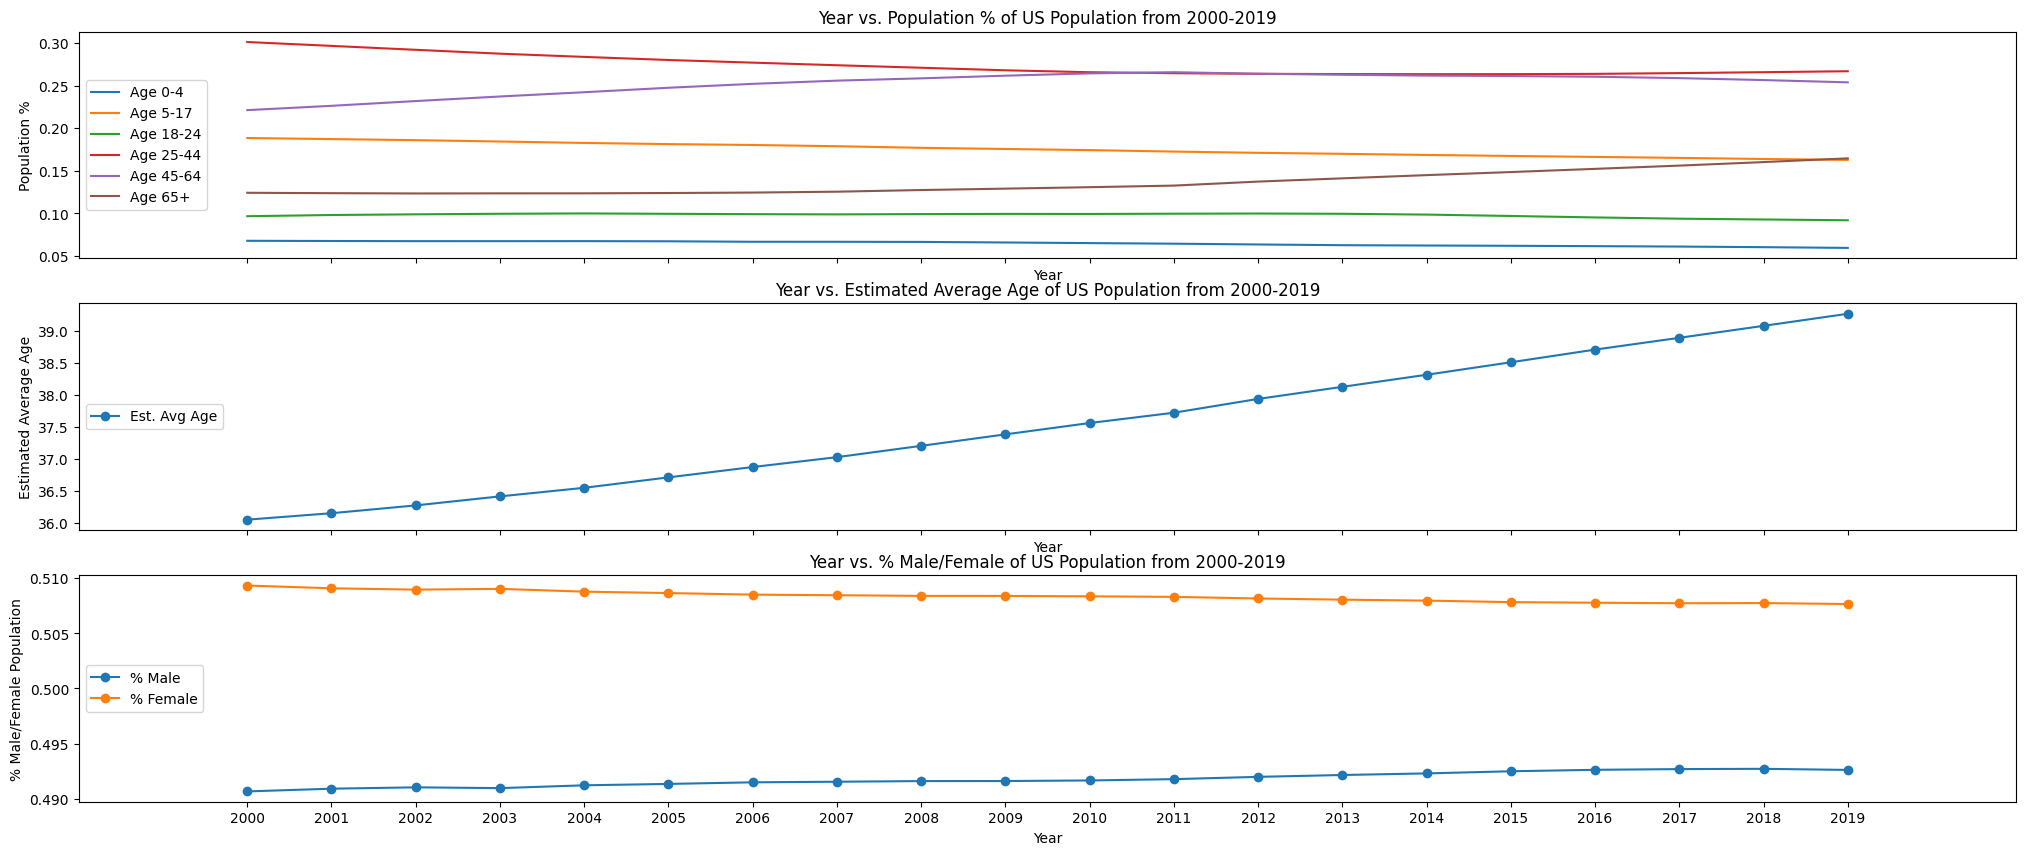

In [17]:
'''
    POPULATION CHARTS
'''
fig_width = len(filtered_pop)*1.25
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(fig_width, 10))

ax1.plot(filtered_pop['Year'],
         filtered_pop['% Population 0-4'], label='Age 0-4')
ax1.plot(filtered_pop['Year'],
         filtered_pop['% Population 5-17'], label='Age 5-17')
ax1.plot(filtered_pop['Year'],
         filtered_pop['% Population 18-24'], label='Age 18-24')
ax1.plot(filtered_pop['Year'],
         filtered_pop['% Population 25-44'], label='Age 25-44')
ax1.plot(filtered_pop['Year'],
         filtered_pop['% Population 45-64'], label='Age 45-64')
ax1.plot(filtered_pop['Year'],
         filtered_pop['% Population 65+'], label='Age 65+')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population %')
ax1.set_title('Year vs. Population % of US Population from 2000-2019')
ax1.legend(loc='center left')

ax2.plot(filtered_pop['Year'], filtered_pop['Average Age'],
         label='Est. Avg Age', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('Estimated Average Age')
ax2.set_title('Year vs. Estimated Average Age of US Population from 2000-2019')
ax2.legend(loc='center left')

ax3.plot(filtered_pop['Year'],
         filtered_pop['% Male Population'], label='% Male', marker='o')
ax3.plot(filtered_pop['Year'], filtered_pop['% Female Population'],
         label='% Female', marker='o')
ax3.set_xlabel('Year')
ax3.set_ylabel('% Male/Female Population')
ax3.set_title('Year vs. % Male/Female of US Population from 2000-2019')
ax3.legend(loc='center left')


plt.xticks(filtered_pop['Year'])
plt.xlim(1998, 2021)

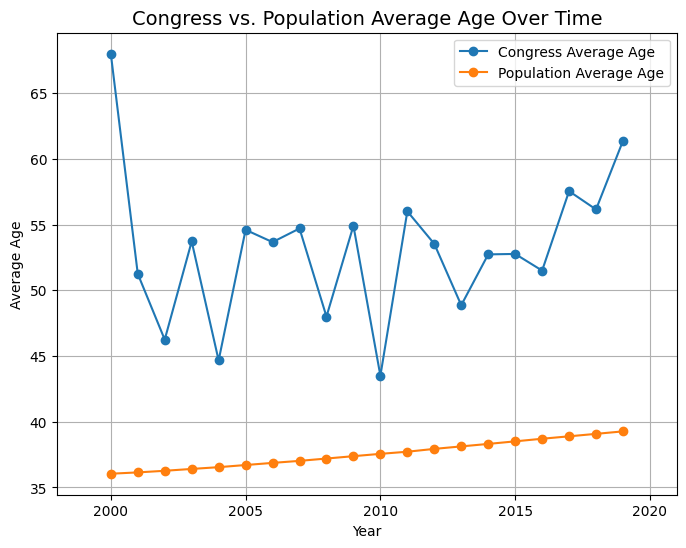

In [50]:
''' CONGRESS VS. POPULATION AGE BY YEAR '''
congress_age_by_year = group_age_start(all_legislators)
congress_age_by_year['year'] = congress_age_by_year['start'].dt.year
congress_age_by_year['average_age'] = pd.to_numeric(
    congress_age_by_year['average_age'], errors='coerce')

congress_age_by_year = congress_age_by_year.groupby('year').agg(
    avg_age=('average_age', 'mean')
).reset_index()

congress_age_by_year = congress_age_by_year[congress_age_by_year['year'] >= 1999]
congress_age_by_year = congress_age_by_year[congress_age_by_year['year'] <= 2019]
combined_age_over_time = pd.merge(congress_age_by_year[['year', 'avg_age']], filtered_pop[[
                                  'Year', 'Average Age']], left_on='year', right_on='Year')

plt.figure(figsize=(8, 6))
plt.plot(combined_age_over_time['year'], combined_age_over_time['avg_age'],
         marker='o', label='Congress Average Age')
plt.plot(combined_age_over_time['year'], combined_age_over_time['Average Age'],
         marker='o', label='Population Average Age')

plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Congress vs. Population Average Age Over Time', fontsize=14)
plt.legend()
plt.grid(True)
plt.xlim(1998, 2021)
plt.show()

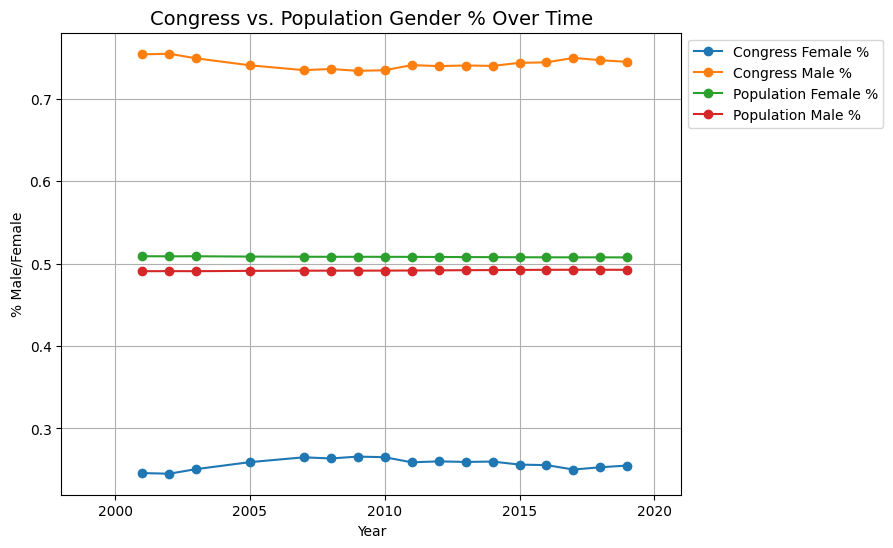

In [53]:
''' CONGRESS VS. POPULATION GENDER BY YEAR '''
def group_gender_start(df):
    # Extract year from the start date
    df['year'] = df['start'].dt.year
    
    # Group by year and gender to calculate counts for each year
    gender_count = df.groupby(['year', 'gender']).agg(
        count=('gender', 'count')
    ).reset_index()

    # Pivot to create columns for M/F counts
    pivoted = gender_count.pivot(
        index='year', columns='gender', values='count').fillna(0)

    # Add cumulative counts for each gender
    pivoted['M_cumulative'] = pivoted.get('M', 0).cumsum()
    pivoted['F_cumulative'] = pivoted.get('F', 0).cumsum()

    # Calculate total cumulative members
    pivoted['total_cumulative'] = pivoted['M_cumulative'] + pivoted['F_cumulative']

    # Calculate percentages
    pivoted['percent_M'] = (pivoted['M_cumulative'] / pivoted['total_cumulative'])
    pivoted['percent_F'] = (pivoted['F_cumulative'] / pivoted['total_cumulative'])

    # Reset index for final output
    pivoted = pivoted.reset_index()
    return pivoted

inc_age_gender = group_gender_start(incumbent)
inc_age_gender

inc_age_gender = inc_age_gender[inc_age_gender['year'] >= 1999]
inc_age_gender = inc_age_gender[inc_age_gender['year'] <= 2019]
combined_gender_over_time = pd.merge(inc_age_gender[['year', 'percent_F', 'percent_M']], filtered_pop[[
                                     'Year', '% Female Population', '% Male Population']], left_on='year', right_on='Year')
plt.figure(figsize=(8, 6))
plt.plot(combined_gender_over_time['year'],
         combined_gender_over_time['percent_F'], marker='o', label='Congress Female %')
plt.plot(combined_gender_over_time['year'],
         combined_gender_over_time['percent_M'], marker='o', label='Congress Male %')
plt.plot(combined_gender_over_time['year'],
         combined_gender_over_time['% Female Population'], marker='o', label='Population Female %')
plt.plot(combined_gender_over_time['year'],
         combined_gender_over_time['% Male Population'], marker='o', label='Population Male %')

plt.xlabel('Year')
plt.ylabel('% Male/Female')
plt.title('Congress vs. Population Gender % Over Time', fontsize=14)
# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlim(1998, 2021)
plt.show()